# 2.4.4. Нейросетевая модель torch.embedding.  


Видеоуроки:  
2.4.1. Векторное представление единиц текста.  
2.4.2. Обучение нейросетевой модели word2vec.  
2.4.3. Использование обученных моделей RusVectōrēs.  
**2.4.4. Нейросетевая модель torch.embedding.**  

Дополнительные материалы:  
2.4.5. Использование обученных моделей RusVectōrēs для классификации (анализа тональности) текста.  
2.4.6. Использование моделей Hugging Face для классификации (анализа тональности) текста.  

In [2]:
import matplotlib.pyplot as plt
import warnings
import logging
from utils import reset_random_seeds
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.decomposition import PCA
from string import punctuation

RANDOM_SEED = 42
reset_random_seeds(RANDOM_SEED)
plt.style.use('ggplot')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
warnings.filterwarnings('ignore')

Как и в случае с бинарным (OneHot) кодированием, (где слова представляются в виде вектора, с 0 на всех позициях, кроме индекса заданного слова, равного 1), нам нужно задать индекс для каждого слова словаря. Это можно сравнить в с ключами в таблице поиска. Все эмбеддинги слов словаря сохраняются в матрице размера $|V| x D$, где $|V|$ - количество слов словаря, $D$ - размер эмбеддинга (выходного вектора). Слово с индексом $i$ будет сохранено в $i$ строке этой матрицы.  
`torch.nn.Embeddings` - модуль, который позволяет вам использовать эмбеддинги. Принимает 2 параметра - размер словаря и размер эмбеддинга.  
В словаре `word_to_ix` сохраним соответствие слов их индексам.  

In [3]:
word_to_ix = {'привет': 0, 'мир': 1}
embeds = nn.Embedding(2, 5)  # 2 слова в словаре, 5 - размер эмбеддинга

lookup_tensor = torch.tensor([word_to_ix['привет']], dtype=torch.long)

hello_embed = embeds(lookup_tensor)

print(hello_embed)

tensor([[ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229]],
       grad_fn=<EmbeddingBackward0>)


## N-граммная языковая модель.  

В n-граммной языковой модели, наша задача - посчитать вероятность $w$ при учете контекста:  

$P(w_i∣w_i−1,w_i−2,…,w_i−n+1)$  

In [4]:
def delete_punctuation(text: str) -> str:
    """
    Удаление стоп-слов.

    Args:
        text (str): Исходный текст.
    Returns:
        str: Обработанный текст.
    """

    return ' '.join([t for t in text.split() if t not in punctuation])

corpora = [
    'На лугу корова щиплет травку',
    'На лугу овца щиплет травку',
    'Собака ест сухой корм',
    'Кошка ест сухой корм',
]

text_processors = [
    str.lower,
    delete_punctuation,
]

for proc in text_processors:
    for i, text in enumerate(corpora):
        corpora[i] = proc(text)

tokenized_corpora = [text.split() for text in corpora]

vocab = set([tokens for sentence in tokenized_corpora for tokens in sentence])

word_to_ix = {w: idx for (idx, w) in enumerate(vocab)}

vocab_size = len(vocab)

print('word_to_ix:', word_to_ix)
print('vocab_size:', vocab_size)

CONTEXT_SIZE = 3
EMBEDDING_DIM = 4

ngrams = [
    (
        [sent[i - j - 1] for j in range(CONTEXT_SIZE)],
        sent[i]
    )
    for sent in tokenized_corpora
    for i in range(CONTEXT_SIZE, len(sent))
]

# Print the first 3, just so you can see what they look like.
print(ngrams[:3])

word_to_ix: {'корова': 0, 'собака': 1, 'ест': 2, 'корм': 3, 'овца': 4, 'лугу': 5, 'щиплет': 6, 'на': 7, 'травку': 8, 'сухой': 9, 'кошка': 10}
vocab_size: 11
[(['корова', 'лугу', 'на'], 'щиплет'), (['щиплет', 'корова', 'лугу'], 'травку'), (['овца', 'лугу', 'на'], 'щиплет')]


In [20]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size: int, embedding_dim: int, context_size: int):
        """
        N-граммная языковая модель.

        Args:
            vocab_size (int): размер словаря.
            embedding_dim (int): размер эмбеддинга.
            context_size (int): размер контекстного окна.
        """

        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

N_EPOCHS = 500
for epoch in range(N_EPOCHS):
    total_loss = 0
    for context, target in ngrams:

        # Шаг 1. Подготовка данных на вход модели (переводим слова в индексы и оборачиваем в тензоры)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Шаг 2. PyTorch запоминает предыдущие градиенты. Перед новой итерацией вы должны обнулить их.
        model.zero_grad()

        # Шаг 3. Запускаем прямое прохождение сети, получем логарифм вероятности для следующих слов.
        log_probs = model(context_idxs)

        # Шаг 4. Вычисляем функцию потерь.
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Шаг 5. Запускаем обратный проход и обновляем градиенты.
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 50 == 0:
        print(f'Loss at epo {epoch}: {total_loss}')

Loss at epo 0: 15.453016757965088
Loss at epo 50: 7.888537764549255
Loss at epo 100: 4.159153550863266
Loss at epo 150: 2.497830167412758
Loss at epo 200: 1.6649567261338234
Loss at epo 250: 1.190372534096241
Loss at epo 300: 0.8942529186606407
Loss at epo 350: 0.698239354416728
Loss at epo 400: 0.5627048444002867
Loss at epo 450: 0.46552196331322193


In [6]:
def similarity(v: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
    """Вычисление меры близости - косинусное расстояние."""
    return torch.dot(v,u) / (torch.norm(v)*torch.norm(u))


def vectorize(word: str) -> torch.Tensor:
    """Получить вектор текста."""
    return model.embeddings.weight[word_to_ix[word]]

In [23]:
# Выведем эмбеддинг какого-нибудь слова.
vectorize('корова')

tensor([-0.8783, -1.3238,  0.5751,  2.6152], grad_fn=<SelectBackward0>)

Посмотрим на близость слов:

In [22]:
# {word: [(word, similarity)]}
results = {}

words = 'корова овца собака кошка'.split(' ')
for w1 in words:
    results[w1] = []
    for w2 in vocab:
        w1v = vectorize(w1)
        w2v = vectorize(w2)
        d = similarity(w1v, w2v).item()
        results[w1].append((w2, d))

    results[w1] = sorted(results[w1], key=lambda item: item[1], reverse=True)

col_width = 15
print(*[c.ljust(col_width) for c in ['Слово', 'Сосед', 'Расстояние']])
print('-'*col_width*3)

for w1 in results:
    for i in range(3):
        d = round(results[w1][i][1], 2)
        print(w1.ljust(col_width), results[w1][i][0].ljust(col_width), d)
    print()

Слово           Сосед           Расстояние     
---------------------------------------------
корова          корова          1.0
корова          корм            0.64
корова          овца            0.5

овца            овца            1.0
овца            на              0.79
овца            корм            0.69

собака          собака          1.0
собака          травку          0.72
собака          ест             0.67

кошка           кошка           1.0
кошка           лугу            0.39
кошка           травку          0.34



In [21]:
w_vects = [vectorize(w) for w in words]
neighbors = []
for v1 in w_vects:
    dist = []
    for v2, w2 in zip(w_vects, words):
        d = similarity(v1, v2).item()
        dist.append((d, w2))
    dist = sorted(dist, key=lambda d: d[0], reverse=True)
    n = dist[1][1]
    neighbors.append(n)

for w, n in zip(words, neighbors):
    print(w, n)
    print()

корова овца

овца корова

собака кошка

кошка собака



И выведем на графике несколько слов, предварительно уменьшив размерность векторов слов методом главных компонент:

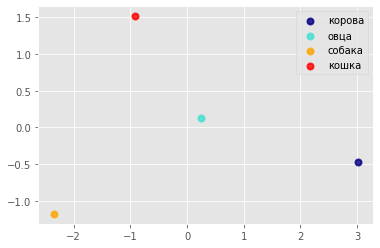

In [24]:
words = 'корова овца собака кошка'.split(' ')
xs = [model.embeddings.weight[word_to_ix[w]].detach().tolist() for w in words]
xs_r = PCA(n_components=2).fit(xs).transform(xs)

plt.figure()
colors = ['navy', 'turquoise', 'orange', 'red']
lw = 2

# for color, word in zip(colors, words):
for i, word in enumerate(words):
    color = colors[i]
    plt.scatter(
        xs_r[i][0],
        xs_r[i][1],
        color=color,
        alpha=0.8,
        lw=lw,
        label=word,
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.show()